In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import os
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/us-airbnb-open-data/AB_US_2020.csv


In [2]:
df = pd.read_csv('/kaggle/input/us-airbnb-open-data/AB_US_2020.csv')
df.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,NaN,28804,35.65146,-82.62792,Private room,60,1,138,16/02/20,1.14,1,0,Asheville
1,80905,French Chic Loft,427027,Celeste,NaN,28801,35.59779,-82.55540,Entire home/apt,470,1,114,07/09/20,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,NaN,28801,35.60670,-82.55563,Entire home/apt,75,30,89,30/11/19,0.81,2,298,Asheville
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,NaN,28806,35.57864,-82.59578,Entire home/apt,90,1,267,22/09/20,2.39,5,0,Asheville
4,160594,Historic Grove Park,769252,Elizabeth,NaN,28801,35.61442,-82.54127,Private room,125,30,58,19/10/15,0.52,1,0,Asheville


In [3]:
df.shape

(226030, 17)

In [4]:
df.isnull().sum()/len(df)*100

id                                 0.000000
name                               0.012388
host_id                            0.000000
host_name                          0.014600
neighbourhood_group               51.252046
neighbourhood                      0.000000
latitude                           0.000000
longitude                          0.000000
room_type                          0.000000
price                              0.000000
minimum_nights                     0.000000
number_of_reviews                  0.000000
last_review                       21.502455
reviews_per_month                 21.502455
calculated_host_listings_count     0.000000
availability_365                   0.000000
city                               0.000000
dtype: float64

In [5]:
df.drop(['neighbourhood_group','last_review','name'],axis=1,inplace=True)

In [6]:
df.dtypes

id                                  int64
host_id                             int64
host_name                          object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
city                               object
dtype: object

In [7]:
df.columns

Index(['id', 'host_id', 'host_name', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'city'],
      dtype='object')

In [8]:
df['reviews_per_month'].fillna(df['reviews_per_month'].mean(),inplace=True)

In [9]:
df.dropna().shape

(225997, 14)

In [10]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,2.260300e+05,2.260300e+05,226030.000000,226030.000000,226030.000000,2.260300e+05,226030.000000,226030.000000,226030.000000,226030.000000
mean,2.547176e+07,9.352385e+07,35.662829,-103.220662,219.716529,4.525490e+02,34.506530,1.431450,16.698562,159.314856
std,1.317814e+07,9.827422e+07,6.849855,26.222091,570.353609,2.103376e+05,63.602914,1.491304,51.068966,140.179628
min,1.090000e+02,2.300000e+01,18.920990,-159.714900,0.000000,1.000000e+00,0.000000,0.010000,1.000000,0.000000
25%,1.515890e+07,1.399275e+07,32.761783,-118.598115,75.000000,1.000000e+00,1.000000,0.340000,1.000000,0.000000
50%,2.590916e+07,5.138266e+07,37.261125,-97.817200,121.000000,2.000000e+00,8.000000,1.370000,2.000000,140.000000
75%,3.772624e+07,1.497179e+08,40.724038,-76.919322,201.000000,7.000000e+00,39.000000,1.620000,6.000000,311.000000
max,4.556085e+07,3.679176e+08,47.734620,-70.995950,24999.000000,1.000000e+08,966.000000,44.060000,593.000000,365.000000


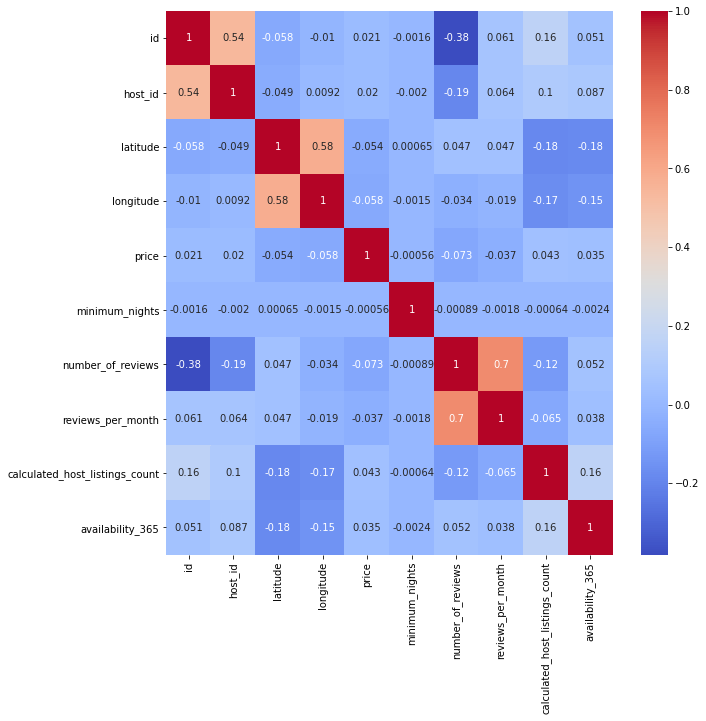

In [11]:
plt.rcParams['figure.figsize']=10,10
sns.heatmap(df.corr(), cmap='coolwarm', annot=True)

In [12]:
X = df.drop(['price'], axis=1)
y = df.price

In [13]:
X_train, X_test , y_train , y_test = train_test_split(X , y , random_state=1)

In [14]:
numerical_cols = [cname for cname in X.columns if 
                X[cname].dtype in ['int64', 'float64']]

categorical_cols = [cname for cname in X.columns if
                    X[cname].nunique() < 50 and 
                    X[cname].dtype in ['object', 'bool']]

numerical_transformer = SimpleImputer(strategy='constant')

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
])

model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.02, max_delta_step=0, max_depth=4,
             min_child_weight=0.0,n_estimators=1250, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

clf.fit(X_train, y_train, model__verbose=False) 
preds = clf.predict(X_test)

print('RMSE:', mean_squared_error(y_test, preds, squared=False))

RMSE: 455.11291043017553


In [15]:
preds = clf.predict(X)
output = pd.DataFrame({'id': X.id,
                       'price': preds})
output.to_csv('submission.csv', index=False)